In [1]:
%pip install -Uqq fastai duckduckgo_search ipywidgets

Note: you may need to restart the kernel to use updated packages.


Installing up to date version of fastai and duckduckgo_search

In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *

food_list = {'normal_food' : ['ice cream', 'milkshake', 'fried chicken', 'french fries', 'pizza', 'chocolate', 'sushi roll', 'nigiri', 'sashimi', 'peking duck', 'baklava', 'burger', 'donut', 'dumpling', 'pasta', 'sandwhich', 'hot dog', 'cake', 'pie', 'burrito', 'taco', 'chicken wings'], 'indian_food' : ['indian curry', 'butter chicken', 'chicken tikka masala', 'tandoori chicken', 'biryani', 'dal makhni', 'samosa', 'pani puri', 'palak paneer', 'naan bread', 'gulab jamun', 'kulfi', 'soan papdi', 'gajar ka halwa', 'mysore pak', 'mango lassi', 'lassi drink']}

def search_images(term, max_images=30):
    print(f"Searching for {term}")
    with DDGS() as ddgs:
        return L(ddgs.images(term, max_results=max_images)).itemgot('image')


# Testing
# urls = search_images('daily training running shoe photos', max_images=1)
# urls[0]

Searches for and downloads training images

In [3]:
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

path = Path("food_type")

def get_images(search_topics):
    for type, topic_list in search_topics.items():
        dest = (path/type)
        dest.mkdir(exist_ok=True, parents=True)
        for topic in topic_list:
            download_images(dest, urls=search_images(f'{topic} photos'))
            resize_images(dest, max_size=400, dest=dest)
    
get_images(food_list)

Searching for ice cream photos
Searching for milkshake photos
Searching for fried chicken photos
Searching for french fries photos


/opt/homebrew/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for pizza photos


/opt/homebrew/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for chocolate photos
Searching for sushi roll photos
Searching for nigiri photos
Searching for sashimi photos
Searching for peking duck photos
Searching for baklava photos
Searching for burger photos
Searching for donut photos
Searching for dumpling photos
Searching for pasta photos
Searching for sandwhich photos
Searching for hot dog photos
Searching for cake photos
Searching for pie photos
Searching for burrito photos
Searching for taco photos
Searching for chicken wings photos
Searching for indian curry photos
Searching for butter chicken photos
Searching for chicken tikka masala photos
Searching for tandoori chicken photos
Searching for biryani photos
Searching for dal makhni photos
Searching for samosa photos
Searching for pani puri photos
Searching for palak paneer photos
Searching for naan bread photos
Searching for gulab jamun photos
Searching for kulfi photos
Searching for soan papdi photos
Searching for gajar ka halwa photos
Searching for mysore pak photos
Searching

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [4]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

13

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

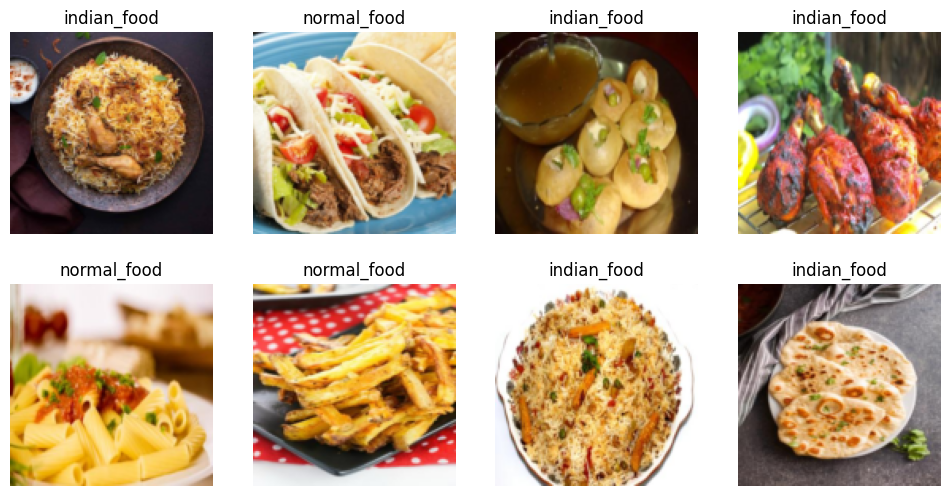

In [5]:
food = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))


food = food.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = food.dataloaders(path)

dls.train.show_batch(max_n=8, nrows=2)

Trains image recognition model using the data and the pre-existing `resenet18` model. 

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.881857,0.420616,0.137698,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.407550,0.236256,0.072235,00:12
1,0.257871,0.189380,0.040632,00:13
2,0.156542,0.203083,0.051919,00:12
3,0.099761,0.196586,0.031603,00:12
4,0.065782,0.191588,0.047404,00:12
5,0.044388,0.178317,0.042889,00:13
6,0.029903,0.205970,0.040632,00:13
7,0.020581,0.193429,0.040632,00:13
8,0.014490,0.185890,0.040632,00:13
9,0.009288,0.196617,0.040632,00:13


Shows common errors in training

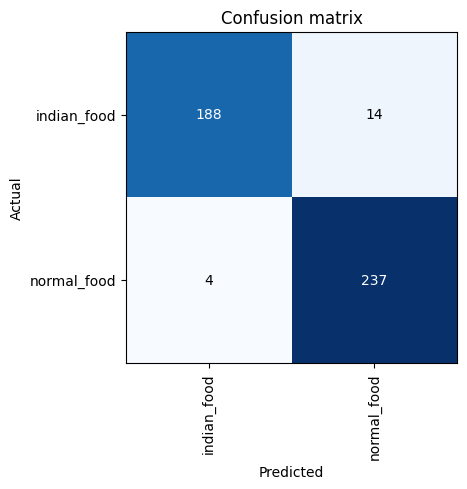

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Shows images with top losses: Most confidently wrong predictions or Most unconfident right predicitions

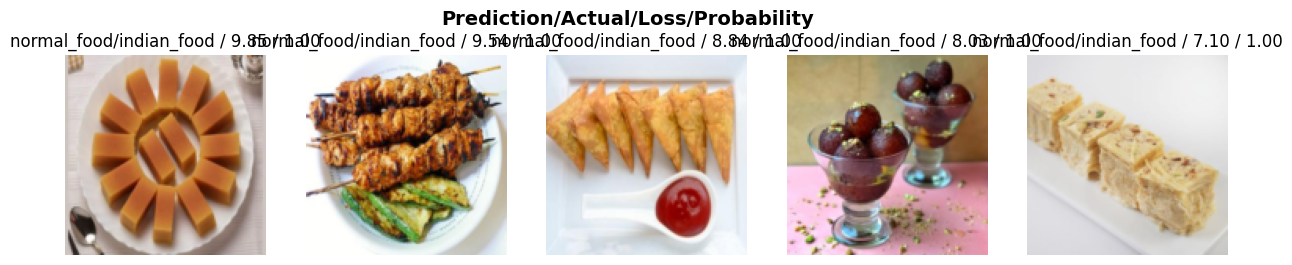

In [8]:
interp.plot_top_losses(5, nrows=1)

Clean model based on `top_losses` images:

Create model with possible problems with data in mind so that data cleaning can be automated

In [9]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)

for idx in cleaner.delete():
    cleaner.fns[idx].unlink()
    
for idx,cat in cleaner.change(): 
    shutil.move(str(cleaner.fns[idx]), path/cat)
     

Run optimization several more times

In [10]:
for _ in range(4):
    learn.fine_tune(5)
    interp = ClassificationInterpretation.from_learner(learn)
    
    cleaner = ImageClassifierCleaner(learn)

    for idx in cleaner.delete():
        cleaner.fns[idx].unlink()
    
    for idx,cat in cleaner.change(): 
        shutil.move(str(cleaner.fns[idx]), path/cat)

epoch,train_loss,valid_loss,error_rate,time
0,0.001380,0.257641,0.038375,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.000821,0.250549,0.038375,00:13
1,0.056202,0.417375,0.063205,00:13
2,0.051171,0.292933,0.042889,00:13
3,0.036399,0.268073,0.040632,00:14
4,0.023882,0.267679,0.042889,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.004760,0.266726,0.045147,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.001090,0.387988,0.054176,00:14
1,0.007059,0.637504,0.108352,00:13
2,0.029837,0.305812,0.056433,00:13
3,0.026566,0.272782,0.031603,00:13
4,0.020878,0.257355,0.031603,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.008876,0.262351,0.036117,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.009591,0.334993,0.054176,00:13
1,0.019691,0.220741,0.033860,00:14
2,0.019212,0.263483,0.036117,00:14
3,0.020093,0.297996,0.031603,00:14
4,0.012238,0.301784,0.031603,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.007533,0.283703,0.033860,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.003473,0.313942,0.036117,00:16
1,0.012668,0.251574,0.042889,00:14
2,0.018966,0.341978,0.045147,00:14
3,0.019831,0.283800,0.031603,00:14
4,0.014208,0.267768,0.031603,00:15


Check downloaded images with model

In [11]:
def will_akash_eat(image_name) -> bool:
    food_type, _, _ = learn.predict(image_name)
    if food_type == 'indian_food':
        return True
    else:
        return False

Export readymade model for use

In [12]:
learn.export('Akash_Food_or_Not.pkl')